In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [3]:
df=pd.read_csv('Emotion_final.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
df['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [5]:
df=df.dropna()

In [6]:
X=df.drop('Emotion',axis=1)
y=df['Emotion']

In [7]:
### Vocabulary size
voc_size=10000

In [8]:
messages=X.copy()
messages.reset_index(inplace=True)

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jagadeesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [15]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

In [16]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [17]:
#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))
print(l)

35


In [18]:
sent_length=35
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2729 7645 9780]
 [   0    0    0 ... 8467 1283 5293]
 [   0    0    0 ... 7645 2935 1270]
 ...
 [   0    0    0 ... 2536 8494  270]
 [   0    0    0 ... 7661  270 7371]
 [   0    0    0 ...    0  270 4287]]


In [19]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2729,
       7645, 9780], dtype=int32)

In [20]:
# Creating model
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           1000000   
                                                                 
 dropout (Dropout)           (None, 35, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                        

In [21]:
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs)
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [22]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

In [24]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=256,callbacks = [model_save])

Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 2.6265 - accuracy: 0.4265
Epoch 1: val_loss improved from inf to 1.34049, saving model to weights.h5
61/61 [==============================] - 8s 100ms/step - loss: 2.6265 - accuracy: 0.4265 - val_loss: 1.3405 - val_accuracy: 0.5521
Epoch 2/10
61/61 [==============================] - ETA: 0s - loss: 1.0592 - accuracy: 0.6946
Epoch 2: val_loss improved from 1.34049 to 0.85902, saving model to weights.h5
61/61 [==============================] - 6s 102ms/step - loss: 1.0592 - accuracy: 0.6946 - val_loss: 0.8590 - val_accuracy: 0.8195
Epoch 3/10
60/61 [============================>.] - ETA: 0s - loss: 0.7554 - accuracy: 0.8439
Epoch 3: val_loss improved from 0.85902 to 0.72511, saving model to weights.h5
61/61 [==============================] - 7s 115ms/step - loss: 0.7545 - accuracy: 0.8441 - val_loss: 0.7251 - val_accuracy: 0.8410
Epoch 4/10
60/61 [============================>.] - ETA: 0s - loss: 0.6444 - accuracy: 0.879

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


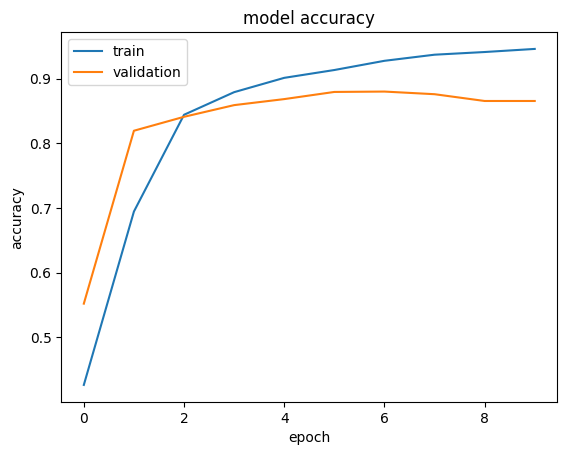

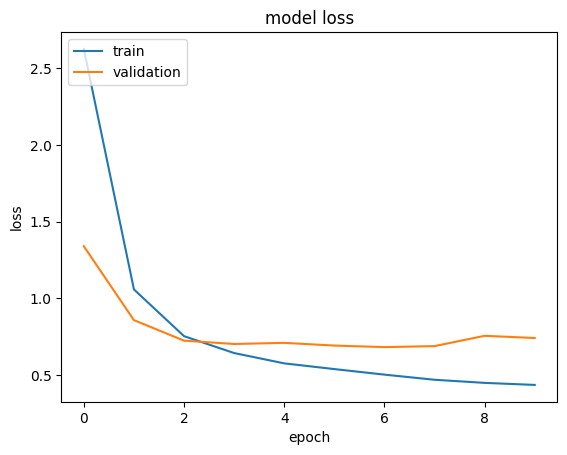

In [25]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
model.load_weights('weights.h5')

In [36]:
y_pred_probabilities = model.predict(X_test)
y_pred = y_pred_probabilities.argmax(axis=-1)
print(y_pred)

135/135 [==============================] - 1s 5ms/step
[2 0 4 ... 0 0 2]


In [37]:
print(accuracy_score(y_test,y_pred))

0.8774464119291705


In [38]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.92199   0.84279   0.88061       617
           1    0.86902   0.78719   0.82609       531
           2    0.89935   0.89935   0.89935      1381
           3    0.72805   0.80818   0.76602       318
           4    0.93103   0.93031   0.93067      1277
           5    0.59494   0.83929   0.69630       168

    accuracy                        0.87745      4292
   macro avg    0.82406   0.85118   0.83317      4292
weighted avg    0.88367   0.87745   0.87908      4292



Confusion Matrix
Axes(0.125,0.11;0.62x0.77)


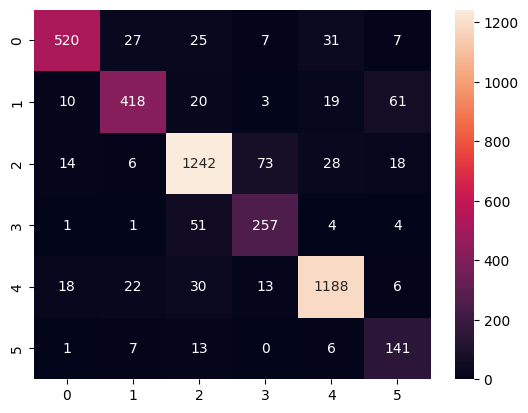

In [39]:
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

In [40]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [41]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [42]:
predict_emotion('I am very happy and joyful today')

1/1 [==============================] - 0s 19ms/step


'happy'

In [43]:
predict_emotion('He is an arrogant and rude person')

1/1 [==============================] - 0s 18ms/step


'anger'

In [44]:
predict_emotion('The teacher is intimidating and scary')

1/1 [==============================] - 0s 21ms/step


'fear'

In [45]:
predict_emotion('Im missing your pressence')

1/1 [==============================] - 0s 16ms/step


'sadness'

In [46]:
predict_emotion('I feel I wanna get you closer and look at your eyes and have a gentle hug')

1/1 [==============================] - 0s 16ms/step


'love'

In [47]:
predict_emotion('I got my best birthday gift')

1/1 [==============================] - 0s 19ms/step


'happy'

In [48]:
predict_emotion('I have seen a amazing art in a gallery')

1/1 [==============================] - 0s 16ms/step


'surprise'